In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, time
from termcolor import colored

## Part _: _

In [16]:
# Read in the results from model predictions
TESTDATADIR = "../data/test_stocks/"
TESTSTOCKS = [
    "AAPL", # Apple
    "AMD",  # AMD
    "AMZN", # Amazon
    "META", # Meta Platforms
    "NFLX", # Netflix
    "QCOM", # Qualcomm
    "SBUX", # Starbucks
    "SCSO", # Cisco
    "TSLA", # Tesla
]
predictions = {}
for stock in TESTSTOCKS:
    predictions[stock] = pd.read_parquet(TESTDATADIR + stock + "_results.parquet")

## Part_: Functionality for simulating trades

In [17]:
# Define the buy signal logic
def buy_shares(cash, shares, actual_price_today, fraction=1.0):
    """
    Buys as many shares as possible with the fraction of available cash.
    Returns the updated cash and new number of shares.
    """
    shares_to_buy = int(cash * fraction / actual_price_today)
    cash -= shares_to_buy * actual_price_today
    shares += shares
    return cash, shares

# Define the sell signal logic
def sell_shares(cash, shares, actual_price_today, fraction=1.0):
    """
    Sells a fraction of the shares owned.
    Returns the updated cash and sets shares to new value.
    """
    shares_to_sell = int(shares * fraction)
    cash += shares_to_sell * actual_price_today
    shares -= shares_to_sell
    return cash, shares

In [18]:
def simulate_trading_strategy(
    actual: np.ndarray,
    predicted: np.ndarray,
    action: callable,
    initial_cash: float = 10000.0
) -> tuple:
    """
    Simulates a trading strategy based on the actual and predicted stock prices.
    The action function should define the buy/sell logic. Which takes the current
    cash, actual price, and predicted price. The function returns a tuple 
    containing the updated cash and number of shares and portfolio value over 
    each iteration. The action function should return a positive value to buy,
    negative value to sell, and zero to do nothing. These abs(result) of the action
    function will be passed to the buy/sell function as fraction of stock to
    sell or fraction of cash used to buy.
    """
    # Initialize variables
    cash = initial_cash
    shares = [0]
    portfolio_value = [initial_cash]
    
    # Shift the predicted prices to align with the actual prices which are a day sooner.
    predicted = np.roll(predicted, -1)
    predicted[-1] = np.nan # Set the last value to NaN since it has no prediction
    
    # Iterate through the actual and predicted prices
    for actual_price_today, predicted_price_tmrw in zip(actual, predicted):
        # Buy shares if the predicted price is higher than the actual price
        action_value = action(actual_price_today, predicted_price_tmrw)
        
        if action_value > 0: # Buy shares
            cash, shares_today = buy_shares(cash, shares[-1], actual_price_today, abs(action_value))
            shares.append(shares_today)
        elif action_value < 0: # Sell shares
            cash, shares_today = sell_shares(cash, shares[-1], actual_price_today, abs(action_value))
            shares.append(shares_today)
        else: # No action
            shares.append(shares[-1])
            
        # Calculate the the portfolio value after each iteration
        portfolio_value.append(cash + shares[-1] * actual_price_today)
    
    return cash, shares, portfolio_value

In [19]:
# This uses a random action function to decide whether to buy or sell shares
def random_action(*args, **kwargs):
    """
    Randomly decides to buy or sell shares.
    """
    return np.random.choice([0, .1, -.1])

# Use the predicted stock to determine value to determine the action.
def prediction_action(actual, predicted):
    """
    Decides to buy or sell shares based on the predicted price.
    """
    if predicted > actual:
        return .1 # Buy with half of the cash
    elif actual > predicted:
        return -.1 # Sell half of the shares
    else:
        return 0 # No action

## Part _: Random Trading

In [20]:
# Random strategy simulation store
random_results = {}

# Simulate the trading strategy for each stock.
for ticker, results in predictions.items():
    
    cash, shares, portfolio_value = simulate_trading_strategy(
        np.array(results['Actual'].values),
        np.array(results['Prediction'].values),
        random_action,
        initial_cash=10000.0
    )
    
    # Create a DataFrame to hold the results
    data = pd.DataFrame({
        'Date': results['Date'],
        'Actual': results['Actual'],
        'Prediction': results['Prediction'],
        'Shares': shares[1:],
        'Portfolio Value': portfolio_value[1:],
        'Yield Percentage': [(pv - portfolio_value[0]) / portfolio_value[0] * 100 for pv in portfolio_value[1:]]
    })
    
    # Add the final cash value to the DataFrame
    random_results[ticker] = data

In [21]:
# Print a header
print("\n{:<8} {:<22} {:<10}".format('Ticker', 'Final Portfolio Value', 'Yield (%)'))
print("-" * 45)

# Iterate through the results and print the final portfolio value and yield percentage
for ticker, data in random_results.items():
    # Get the final portfolio value and yield percentage
    final_value = data['Portfolio Value'].values[-1]
    yield_pct = data['Yield Percentage'].values[-1]
    
    # Format the values
    final_value_str = "${:.2f}".format(final_value)
    yield_str = "{:.2f}%".format(yield_pct)
    
    # Color based on yield (green for positive, red for negative)
    if yield_pct >= 0:
        colored_yield = colored(yield_str, 'green')
    else:
        colored_yield = colored(yield_str, 'red')
        
    # Print the row
    print("{:<8} {:<22} {}".format(ticker, final_value_str, colored_yield))


Ticker   Final Portfolio Value  Yield (%) 
---------------------------------------------
AAPL     $2353.91               -76.46%
AMD      $1283.52               -87.16%
AMZN     $2107.97               -78.92%
META     $5554.62               -44.45%
NFLX     $8173.83               -18.26%
QCOM     $1431.74               -85.68%
SBUX     $1478.20               -85.22%
SCSO     $1605.35               -83.95%
TSLA     $3394.04               -66.06%


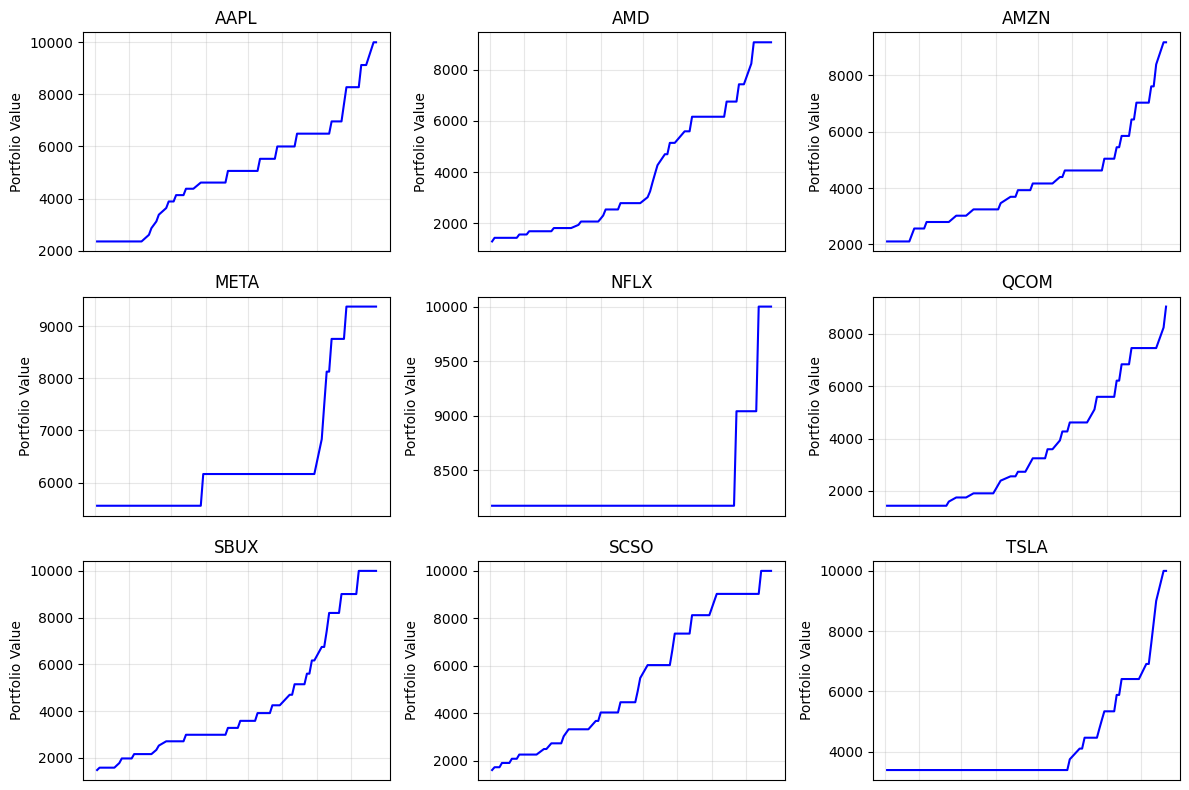

In [22]:
# Plot the portfolio value for each stock, using subplots.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()
for i, (ticker, data) in enumerate(random_results.items()):    
    # Plot the portfolio value
    axes[i].plot(data['Date'], data['Portfolio Value'], label='Portfolio Value', color='blue')
    axes[i].set_title(ticker)
    axes[i].set_ylabel('Portfolio Value')
    
    # Remove date labels to make the plot cleaner
    axes[i].set_xticklabels([])
    axes[i].tick_params(axis='x', which='both', bottom=False)
    
    # Tighten up the plot
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part _: Trading with predictions

In [23]:
# prediction strategy simulation store
pred_results = {}

# Simulate the trading strategy for each stock.
for ticker, results in predictions.items():
    
    cash, shares, portfolio_value = simulate_trading_strategy(
        np.array(results['Actual'].values),
        np.array(results['Prediction'].values),
        prediction_action,
        initial_cash=10000.0
    )
    
    # Create a DataFrame to hold the results
    data = pd.DataFrame({
        'Date': results['Date'],
        'Actual': results['Actual'],
        'Prediction': results['Prediction'],
        'Shares': shares[1:],
        'Portfolio Value': portfolio_value[1:],
        'Yield Percentage': [(pv - portfolio_value[0]) / portfolio_value[0] * 100 for pv in portfolio_value[1:]]
    })
    
    # Add the final cash value to the DataFrame
    pred_results[ticker] = data

In [24]:
# Print a header
print("\n{:<8} {:<22} {:<10}".format('Ticker', 'Final Portfolio Value', 'Yield (%)'))
print("-" * 45)

# Iterate through the results and print the final portfolio value and yield percentage
for ticker, data in pred_results.items():
    # Get the final portfolio value and yield percentage
    final_value = data['Portfolio Value'].values[-1]
    yield_pct = data['Yield Percentage'].values[-1]
    
    # Format the values
    final_value_str = "${:.2f}".format(final_value)
    yield_str = "{:.2f}%".format(yield_pct)
    
    # Color based on yield (green for positive, red for negative)
    if yield_pct >= 0:
        colored_yield = colored(yield_str, 'green')
    else:
        colored_yield = colored(yield_str, 'red')
        
    # Print the row
    print("{:<8} {:<22} {}".format(ticker, final_value_str, colored_yield))


Ticker   Final Portfolio Value  Yield (%) 
---------------------------------------------
AAPL     $10000.00              0.00%
AMD      $5059.74               -49.40%
AMZN     $7449.63               -25.50%
META     $6482.57               -35.17%
NFLX     $8149.54               -18.50%
QCOM     $10000.00              0.00%
SBUX     $4570.96               -54.29%
SCSO     $10000.00              0.00%
TSLA     $2687.74               -73.12%


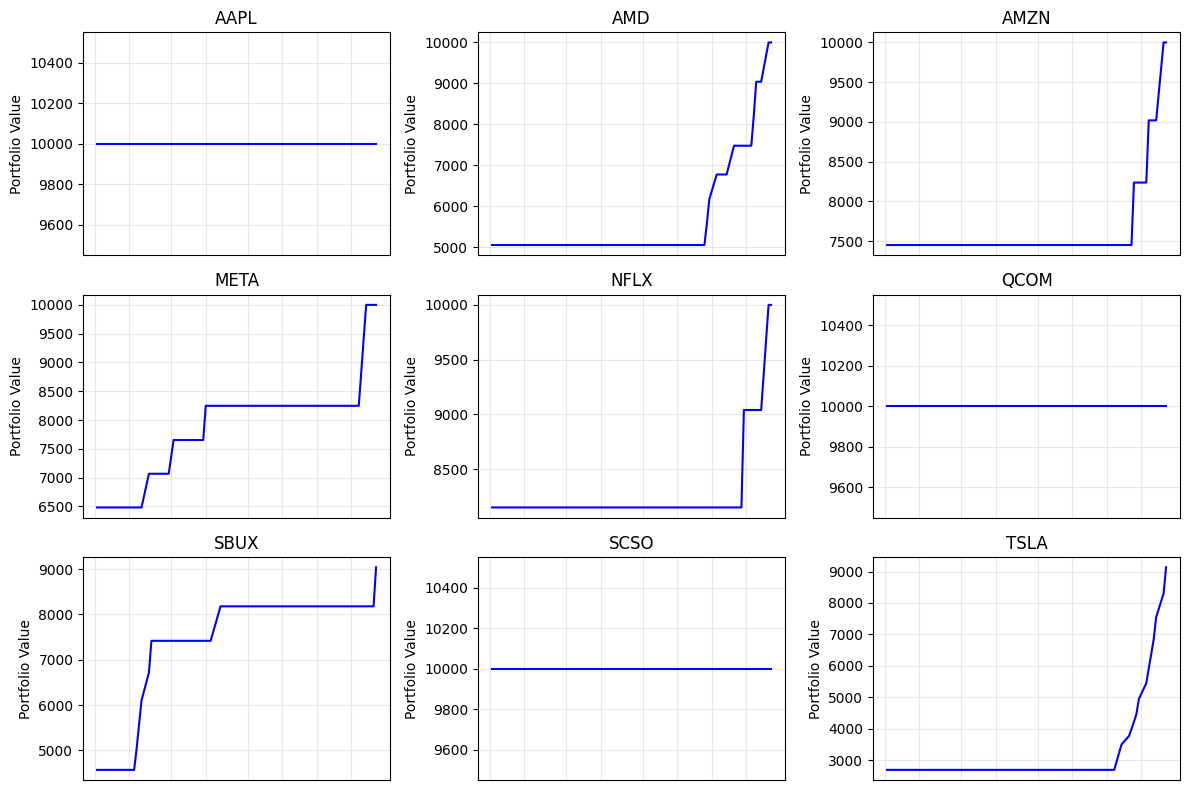

In [25]:
# Plot the portfolio value for each stock, using subplots.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flatten()
for i, (ticker, data) in enumerate(pred_results.items()):
    # Plot the portfolio value
    axes[i].plot(data['Date'], data['Portfolio Value'], label='Portfolio Value', color='blue')
    axes[i].set_title(ticker)
    axes[i].set_ylabel('Portfolio Value')
    
    # Remove date labels to make the plot cleaner
    axes[i].set_xticklabels([])
    axes[i].tick_params(axis='x', which='both', bottom=False)
    
    # Tighten up the plot
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part _: Trading with predictions and market sentiment.

# Following sections are outdated...

In [26]:
# Simulate paper trading for each stock
def simulate_paper_trading(predictions, 
                           initial_investment=10000):
    """
    Simulates paper trading for each stock in the predictions dictionary.
    Returns a DataFrame with the final portfolio value and yield for each stock.
    """
    trading_results = []

    for ticker, results in predictions.items():
        cash = initial_investment
        shares = 0
        portfolio_value = []

        # Iterate through the results DataFrame
        for i in range(len(results) - 1):  # Exclude the last day since we can't predict beyond it
            actual_price_today = results['Actual'].iloc[i]
            predicted_price_tomorrow = results['Prediction'].iloc[i + 1]

            # Buy signal: Predicted price tomorrow > Actual price today
            if predicted_price_tomorrow > actual_price_today:
                cash, shares_bought = buy_shares(cash, shares, actual_price_today)

            # Sell signal: Predicted price tomorrow < Actual price today
            elif predicted_price_tomorrow < actual_price_today and shares > 0:
                cash, shares = sell_shares(cash, shares, actual_price_today)
            

            # Calculate the portfolio value (cash + value of shares)
            portfolio_value.append(cash + shares * actual_price_today)

        # Final portfolio value
        final_portfolio_value = cash + shares * results['Actual'].iloc[-1]
        yield_percentage = ((final_portfolio_value - initial_investment) / initial_investment) * 100

        # Store the results
        trading_results.append({
            'Ticker': ticker,
            'Final Portfolio Value': final_portfolio_value,
            'Yield (%)': yield_percentage
        })

        # Print results for the stock
        print(f"Results for {ticker}:")
        print(f"   Final Portfolio Value: ${final_portfolio_value:.2f}")
        print(f"   Yield: {yield_percentage:.2f}%")
        print()

    # Convert trading results to a DataFrame for display
    trading_results_df = pd.DataFrame(trading_results)
    return trading_results_df

# Run the simulation
trading_results_df = simulate_paper_trading(predictions, initial_investment=10000)

# Display the trading results
display(trading_results_df)

Results for AAPL:
   Final Portfolio Value: $10000.00
   Yield: 0.00%

Results for AMD:
   Final Portfolio Value: $0.77
   Yield: -99.99%

Results for AMZN:
   Final Portfolio Value: $189.50
   Yield: -98.11%

Results for META:
   Final Portfolio Value: $38.00
   Yield: -99.62%

Results for NFLX:
   Final Portfolio Value: $397.10
   Yield: -96.03%

Results for QCOM:
   Final Portfolio Value: $10000.00
   Yield: 0.00%

Results for SBUX:
   Final Portfolio Value: $28.48
   Yield: -99.72%

Results for SCSO:
   Final Portfolio Value: $10000.00
   Yield: 0.00%

Results for TSLA:
   Final Portfolio Value: $203.24
   Yield: -97.97%



,Ticker,Final Portfolio Value,Yield (%)
0,AAPL,10000.00,0.0000
1,AMD,0.77,-99.9923
2,AMZN,189.50,-98.1050
3,META,38.00,-99.6200
4,NFLX,397.10,-96.0290
5,QCOM,10000.00,0.0000
6,SBUX,28.48,-99.7152
7,SCSO,10000.00,0.0000
8,TSLA,203.24,-97.9676


In [27]:
# Print a header
print("\n{:<8} {:<22} {:<10}".format('Ticker', 'Final Portfolio Value', 'Yield (%)'))
print("-" * 45)

# Iterate through the test data and print colored results
for ticker, results in predictions.items():
    final_value = trading_results_df.loc[trading_results_df['Ticker'] == ticker, 'Final Portfolio Value'].values[0]
    yield_pct = trading_results_df.loc[trading_results_df['Ticker'] == ticker, 'Yield (%)'].values[0]
    
    # Format the values
    final_value_str = "${:.2f}".format(final_value)
    yield_str = "{:.2f}%".format(yield_pct)
    
    # Color based on yield (green for positive, red for negative)
    if yield_pct >= 0:
        colored_yield = colored(yield_str, 'green')
    else:
        colored_yield = colored(yield_str, 'red')
    
    # Print the row
    print("{:<8} {:<22} {}".format(ticker, final_value_str, colored_yield))


Ticker   Final Portfolio Value  Yield (%) 
---------------------------------------------
AAPL     $10000.00              0.00%
AMD      $0.77                  -99.99%
AMZN     $189.50                -98.11%
META     $38.00                 -99.62%
NFLX     $397.10                -96.03%
QCOM     $10000.00              0.00%
SBUX     $28.48                 -99.72%
SCSO     $10000.00              0.00%
TSLA     $203.24                -97.97%


In [28]:
  # Create a dataframe from the results.
dataframe_columns = ['Ticker', 'Actual', 'Prediction', 'Date']
trading_results_df = pd.DataFrame(columns=dataframe_columns)
for ticker, results in predictions.items():
    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Ticker': ticker,
        'Actual': results['Actual_Scaled'],
        'Prediction': results['Prediction_Scaled'],
        'Date': results['Date']
    })
    
    # Append to the main DataFrame
    trading_results_df = pd.concat([trading_results_df, results_df], ignore_index=True)
    
# Display the trading results DataFrame
display(trading_results_df)

/tmp/ipykernel_1921/1302842159.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trading_results_df = pd.concat([trading_results_df, results_df], ignore_index=True)


,Ticker,Actual,Prediction,Date
0,AAPL,0.592725,0.532328,2025-03-25
1,AAPL,0.557852,0.553596,2025-03-24
2,AAPL,0.529446,0.521709,2025-03-21
3,AAPL,0.481293,0.500552,2025-03-20
4,AAPL,0.494457,0.464448,2025-03-19
...,...,...,...,...
688,TSLA,0.648682,0.588334,2024-12-06
689,TSLA,0.572209,0.583153,2024-12-05
690,TSLA,0.527403,0.527603,2024-12-04
691,TSLA,0.502171,0.500568,2024-12-03


## Part _: Trading with predictions and market sentiment.